### Dragable Line Function 

In [15]:
def t1_period(df,plt_type):
    """Returns a Derivative Plot and a Plot (Cartesian, Semilog or Log-Log) of the 
       provided parameters on which using a draggable line FWBS and IARF time periods can be identified.
       List of inputs (in same order):
       - Dataframe of Welltest Data
       - Plot type (semilog or log)
    """
    
    import sys
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from matplotlib.lines import Line2D
    from matplotlib.figure import Figure
    matplotlib.use("Qt5Agg")
    from PyQt5 import QtCore, QtGui, QtWidgets, uic
    from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas, NavigationToolbar2QT as NavigationToolbar
    get_ipython().run_line_magic('matplotlib', 'notebook')

    # To ignore warnings generated by the current version of seaborn 
    import warnings                  
    warnings.filterwarnings("ignore")

    Dragpoint_list = []
    class DraggablePoint:

        lock = None #  only one can be animated at a time

        def __init__(self, parent, x=0.1, y=0.1, size=0.1):

            self.parent = parent
            self.point = patches.Ellipse((x, y), size, size * 3, fc='r', alpha=0.5, edgecolor='r')
            self.x = x
            self.y = y
            parent.fig.axes[0].add_patch(self.point)
            self.press = None
            self.background = None
            self.connect()

            # if another point already exist we draw a line
            if self.parent.list_points:
                line_x = [self.parent.list_points[-1].x, self.x]
                line_y = [self.parent.list_points[-1].y, self.y]

                self.line = Line2D(line_x, line_y, color='r', alpha=0.5)
                parent.fig.axes[0].add_line(self.line)


        def connect(self):

            'connect to all the events we need'

            self.cidpress = self.point.figure.canvas.mpl_connect('button_press_event', self.on_press)
            self.cidrelease = self.point.figure.canvas.mpl_connect('button_release_event', self.on_release)
            self.cidmotion = self.point.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)


        def on_press(self, event):

            if event.inaxes != self.point.axes: return
            if DraggablePoint.lock is not None: return
            contains, attrd = self.point.contains(event)
            if not contains: return
            self.press = (self.point.center), event.xdata, event.ydata
            DraggablePoint.lock = self

            # draw everything but the selected rectangle and store the pixel buffer
            canvas = self.point.figure.canvas
            axes = self.point.axes
            self.point.set_animated(True)

            # TODO also the line of some other points needs to be released
            point_number =  self.parent.list_points.index(self)

            if self == self.parent.list_points[0]:
                self.parent.list_points[1].line.set_animated(True)            
            elif self == self.parent.list_points[-1]:
                self.line.set_animated(True)            
            else:
                self.line.set_animated(True)            
                self.parent.list_points[point_number+1].line.set_animated(True)                


            canvas.draw()
            self.background = canvas.copy_from_bbox(self.point.axes.bbox)

            # now redraw just the rectangle
            axes.draw_artist(self.point)

            # and blit just the redrawn area
            canvas.blit(axes.bbox)


        def on_motion(self, event):

            if DraggablePoint.lock is not self:
                return
            if event.inaxes != self.point.axes: return
            self.point.center, xpress, ypress = self.press
            dx = event.xdata - xpress
            dy = event.ydata - ypress
            self.point.center = (self.point.center[0]+dx, self.point.center[1]+dy)

            canvas = self.point.figure.canvas
            axes = self.point.axes
            # restore the background region
            canvas.restore_region(self.background)

            # redraw just the current rectangle
            axes.draw_artist(self.point)

            point_number =  self.parent.list_points.index(self)
            self.x = self.point.center[0]
            self.y = self.point.center[1]


            # We check if the point is A or B        
            if self == self.parent.list_points[0]:
                # or we draw the other line of the point
                self.parent.list_points[1].line.set_animated(True)
                axes.draw_artist(self.parent.list_points[1].line)

            elif self == self.parent.list_points[-1]:
                # we draw the line of the point            
                axes.draw_artist(self.line)    

            else:
                # we draw the line of the point
                axes.draw_artist(self.line)
                #self.parent.list_points[point_number+1].line.set_animated(True)
                axes.draw_artist(self.parent.list_points[point_number+1].line)


            if self == self.parent.list_points[0]:
                # The first point is especial because it has no line
                line_x = [self.x, self.parent.list_points[1].x]
                line_y = [self.y, self.parent.list_points[1].y]      
                # this is were the line is updated
                self.parent.list_points[1].line.set_data(line_x, line_y)

            elif self == self.parent.list_points[-1]:
                line_x = [self.parent.list_points[-2].x, self.x]
                line_y = [self.parent.list_points[-2].y, self.y]
                self.line.set_data(line_x, line_y)        
            else:
                # The first point is especial because it has no line
                line_x = [self.x, self.parent.list_points[point_number+1].x]
                line_y = [self.y, self.parent.list_points[point_number+1].y]      
                # this is were the line is updated
                self.parent.list_points[point_number+1].line.set_data(line_x, line_y)

                line_x = [self.parent.list_points[point_number-1].x, self.x]
                line_y = [self.parent.list_points[point_number-1].y, self.y]
                self.line.set_data(line_x, line_y)        

            # blit just the redrawn area
            canvas.blit(axes.bbox)


        def on_release(self, event):

            'on release we reset the press data'
            if DraggablePoint.lock is not self:
                return

            self.press = None
            DraggablePoint.lock = None

            # turn off the rect animation property and reset the background
            self.point.set_animated(False)

            point_number =  self.parent.list_points.index(self)

            if self == self.parent.list_points[0]:
                self.parent.list_points[1].line.set_animated(False)            
            elif self == self.parent.list_points[-1]:
                self.line.set_animated(False)            
            else:
                self.line.set_animated(False)            
                self.parent.list_points[point_number+1].line.set_animated(False)       


            self.background = None

            # redraw the full figure
            self.point.figure.canvas.draw()

            self.x = self.point.center[0]
            self.y = self.point.center[1]
            print(self.x,self.y)
            Dragpoint_list.append(self.x)

        def disconnect(self):

            'disconnect all the stored connection ids'

            self.point.figure.canvas.mpl_disconnect(self.cidpress)
            self.point.figure.canvas.mpl_disconnect(self.cidrelease)
            self.point.figure.canvas.mpl_disconnect(self.cidmotion)
        

    class MyGraph(FigureCanvas):

        """A canvas that updates itself every second with a new plot."""

        def __init__(self, parent=None, width=5, height=4, dpi=100):

            self.fig = Figure(figsize=(width, height), dpi=dpi)
            self.axes = self.fig.add_subplot(111)

            self.axes.grid(True)

            super(MyGraph, self).__init__(self.fig)
            
            FigureCanvas.__init__(self, self.fig)
            self.setParent(parent)

            FigureCanvas.setSizePolicy(self,
                                        QtWidgets.QSizePolicy.Expanding,
                                        QtWidgets.QSizePolicy.Expanding)
            FigureCanvas.updateGeometry(self)

            # To store the 2 draggable points
            self.list_points = []

            self.show()
            self.plotDraggablePoints()
            self.plot()
            
            
        def plot(self):
            
            ax = self.figure.add_subplot(111)
            if (plt_type == 'semilog'):
                ax.semilogx(df['t'][1:], df['P_dash'][1:],linestyle='--', marker='o', color='b',label='Derivative Plot')
                ax.semilogx(df['t'][1:], df['delP'][1:],linestyle='--', marker='o', color='r',label="delP and (delP)', psia")
                ax.set_title("Semi-Log Plot")
            elif (plt_type == "log"):
                ax.loglog(df['t'][1:], df['P_dash'][1:],linestyle='--', marker='o', color='b',label='Derivative Plot')
                ax.loglog(df['t'][1:], df['delP'][1:],linestyle='--', marker='o', color='r',label="delP and (delP)', psia")
                ax.set_title("Log-Log Plot")

            ax.set_xlabel("Time, hrs")
            ax.set_ylabel("delP and P' (t*dp/dt), psia")
            ax.legend(loc='best')
            
            self.draw()


        def plotDraggablePoints(self, size=1):

            """Plot and define the 2 draggable points of the baseline"""

            # del(self.list_points[:])
            self.list_points.append(DraggablePoint(self, 10, 10, size))
            self.list_points.append(DraggablePoint(self, 50, 50, size))

            self.updateFigure()


        def clearFigure(self):

            """Clear the graph"""

            self.axes.clear()
            self.axes.grid(True)
            del(self.list_points[:])
            self.updateFigure()

            
        def updateFigure(self):

            """Update the graph. Necessary, to call after each plot"""

            self.draw()


    class MainWindow(QtWidgets.QMainWindow):

        def __init__(self, *args, **kwargs):
            super(MainWindow, self).__init__(*args, **kwargs)

            sc = MyGraph()#self, width=5, height=4, dpi=100)

            # Create toolbar, passing canvas as first parament, parent (self, the MainWindow) as second.
            toolbar = NavigationToolbar(sc, self)

            layout = QtWidgets.QVBoxLayout()
            layout.addWidget(toolbar)
            layout.addWidget(sc)

            # Create a placeholder widget to hold our toolbar and canvas.
            widget = QtWidgets.QWidget()
            widget.setLayout(layout)
            self.setCentralWidget(widget)

            self.show()            
            
            
    if __name__ == '__main__':

        app = QtWidgets.QApplication(sys.argv)
        ex = MainWindow()#MyGraph()
        sys.exit(app.exec_())
    return Dragpoint_list

### Implementation

In [2]:
# Important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# To ignore warnings generated by the current version of seaborn 
import warnings                  
warnings.filterwarnings("ignore")

In [3]:
import Welltest
from Welltest import *

In [4]:
d = Input_Data(500,72,6102,70,0.10,17e-6,1.136,0.8,0.2)

In [5]:
#Pwf v/s t
df = pd.read_excel('WTA.xlsx')
df.head()

,t,Pwf
0,0.0000,6102.000000
1,0.0010,6096.784637
2,0.0021,6091.577691
3,0.0034,6085.737839
4,0.0048,6079.184798


In [6]:
df = Well_Dataframe(d,df)
df.head()

,t,Pwf,delP,dt,dP,P_dash
0,0.0000,6102.000000,0.000000,0.0000,0.000000,0.000000
1,0.0010,6096.784637,5.215363,0.0010,5.215363,5.215363
2,0.0021,6091.577691,10.422309,0.0011,5.206946,9.940533
3,0.0034,6085.737839,16.262161,0.0013,5.839852,15.273458
4,0.0048,6079.184798,22.815202,0.0014,6.553042,22.467572


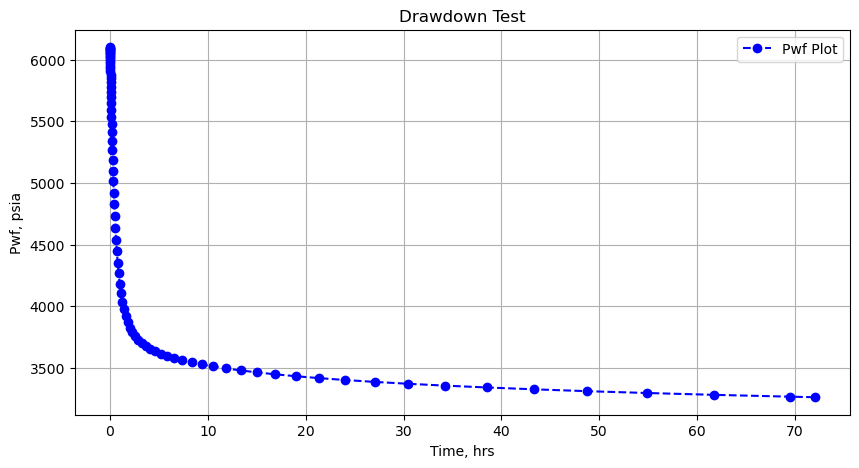

In [7]:
WellTest_Plot(df,'cartesian','t','Pwf','Pwf Plot','Drawdown Test','Time, hrs','Pwf, psia')

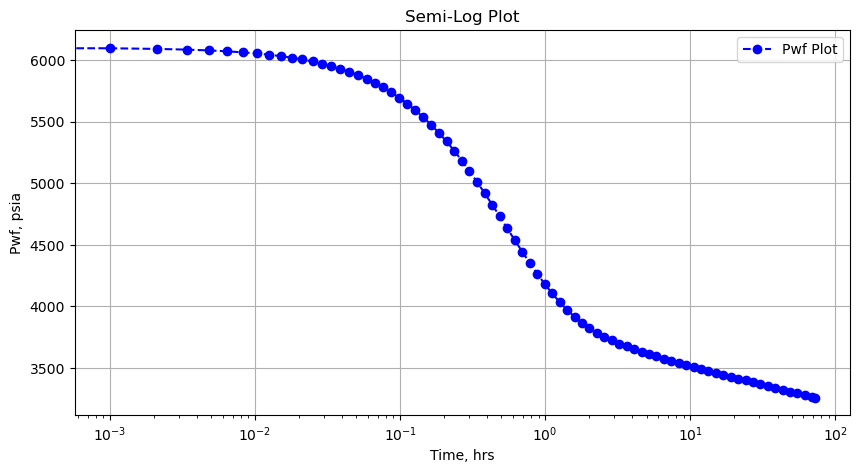

In [8]:
WellTest_Plot(df,'semilog','t','Pwf','Pwf Plot','Semi-Log Plot','Time, hrs','Pwf, psia')

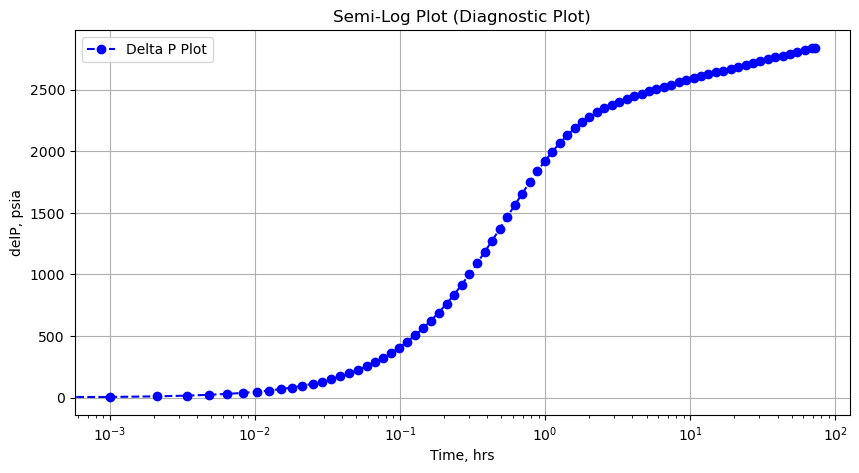

In [9]:
WellTest_Plot(df,'semilog','t','delP','Delta P Plot','Semi-Log Plot (Diagnostic Plot)','Time, hrs','delP, psia')

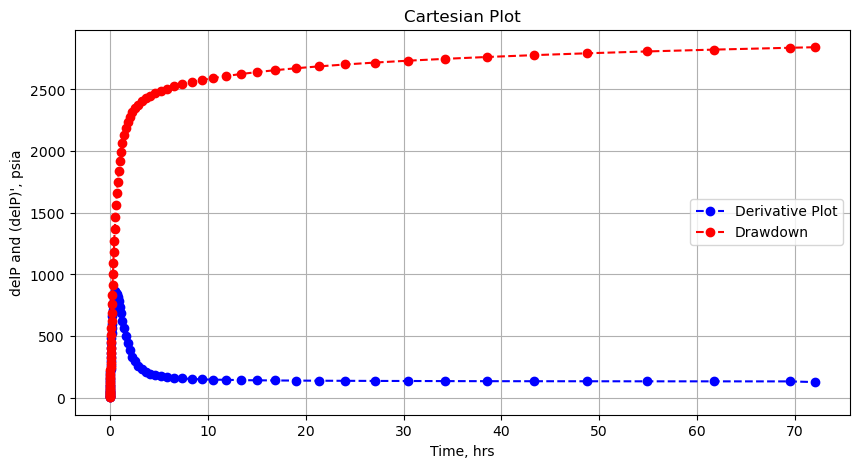

In [10]:
Derivative_Plot(df,'cartesian','t','delP','Drawdown','Cartesian Plot','Time, hrs',"delP and (delP)', psia")

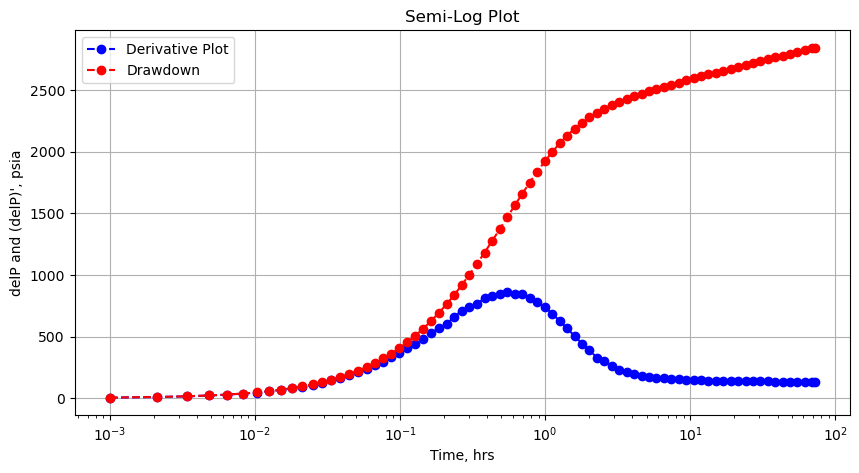

In [11]:
Derivative_Plot(df,'semilog','t','delP','Drawdown','Semi-Log Plot','Time, hrs',"delP and (delP)', psia")

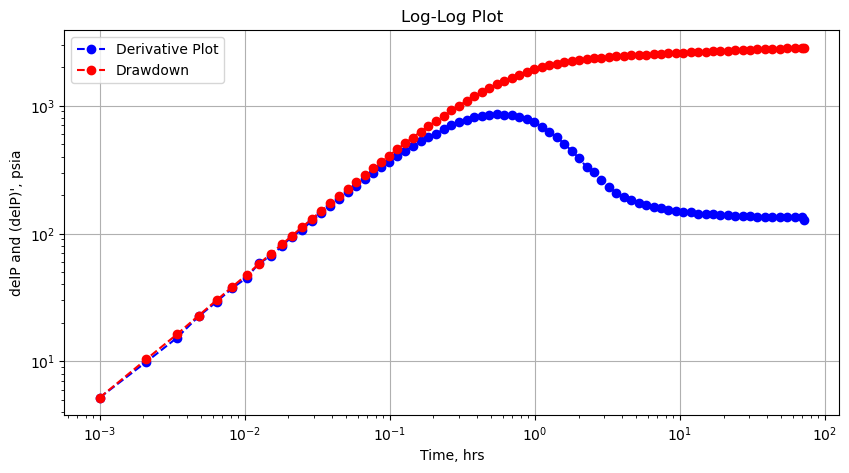

In [12]:
Derivative_Plot(df,'log','t','delP','Drawdown','Log-Log Plot','Time, hrs',"delP and (delP)', psia")

In [16]:
timep = t1_period(df,'log')

SystemExit: 0

In [17]:
timep[-2:]

[]

In [18]:
df__FWBS(0.001,0.04,df)

,t,Pwf,delP,dt,dP,P_dash
1,0.0010,6096.784637,5.215363,0.0010,5.215363,5.215363
2,0.0021,6091.577691,10.422309,0.0011,5.206946,9.940533
3,0.0034,6085.737839,16.262161,0.0013,5.839852,15.273458
4,0.0048,6079.184798,22.815202,0.0014,6.553042,22.467572
5,0.0064,6071.858414,30.141586,0.0016,7.326383,29.305533
6,0.0082,6063.648324,38.351676,0.0018,8.210090,37.401522
7,0.0103,6054.464307,47.535693,0.0021,9.184017,45.045416
8,0.0125,6044.196096,57.803904,0.0022,10.268212,58.342111
9,0.0151,6032.713386,69.286614,0.0026,11.482710,66.688045
10,0.0180,6019.885940,82.114060,0.0029,12.827446,79.618628


In [19]:
df__IARF(10,65,df)

,t,Pwf,delP,dt,dP,P_dash
61,10.55,3509.690918,2592.309082,1.18,16.452912,147.100187
62,11.86,3493.474961,2608.525039,1.31,16.215958,146.810121
63,13.35,3477.465354,2624.534646,1.49,16.009606,143.441772
64,15.02,3461.631504,2640.368496,1.67,15.833851,142.409842
65,16.90,3445.942821,2656.057179,1.88,15.688683,141.031248
66,19.01,3430.389165,2671.610835,2.11,15.553656,140.130330
67,21.39,3414.939963,2687.060037,2.38,15.449202,138.848076
68,24.06,3399.605519,2702.394481,2.67,15.334445,138.182299
69,27.07,3384.345055,2717.654945,3.01,15.260463,137.242773
70,30.45,3369.168881,2732.831119,3.38,15.176174,136.720267


Derivative Method:
Wellbore Storage Constant, Cs: 0.00529 bbl/psi


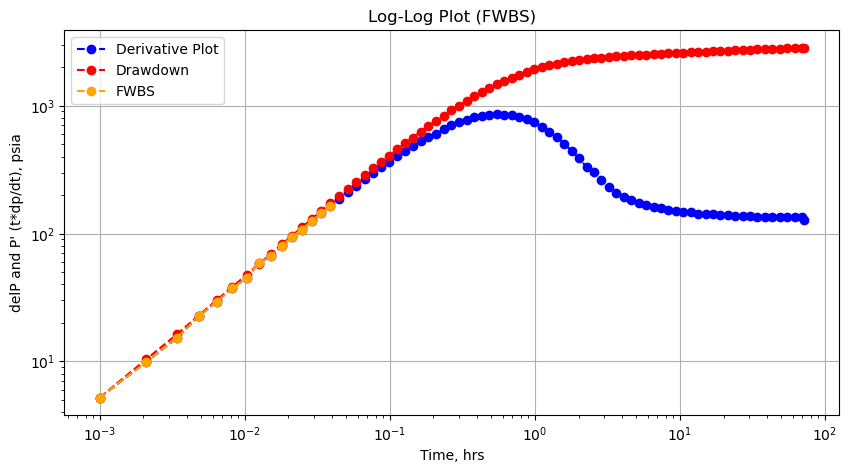

In [20]:
FWBS(0.001,0.04,df,d,'Derivative',0.0212)

Derivative Method:
Reservoir Premability, K: 3.302 mD
Near Wellbore Skin, S: 3.096


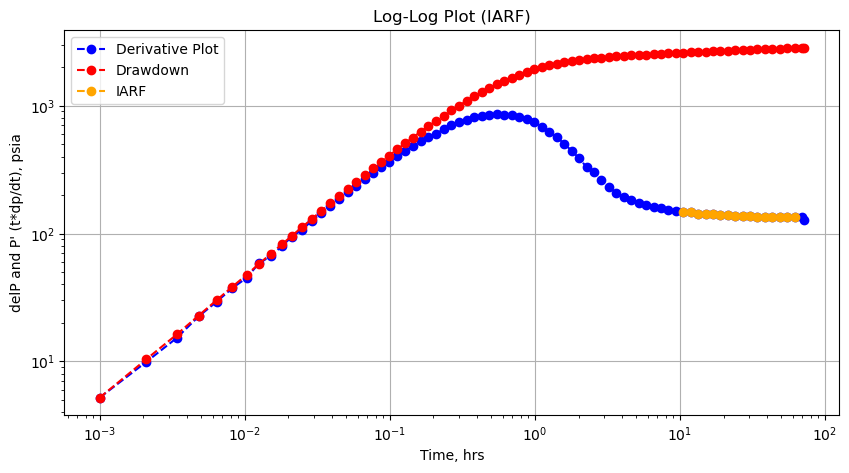

In [21]:
IARF(10,65,df,d,'Derivative',34.26)

Conventional Method:
Wellbore Storage Constant, Cs: 0.00535 bbl/psi


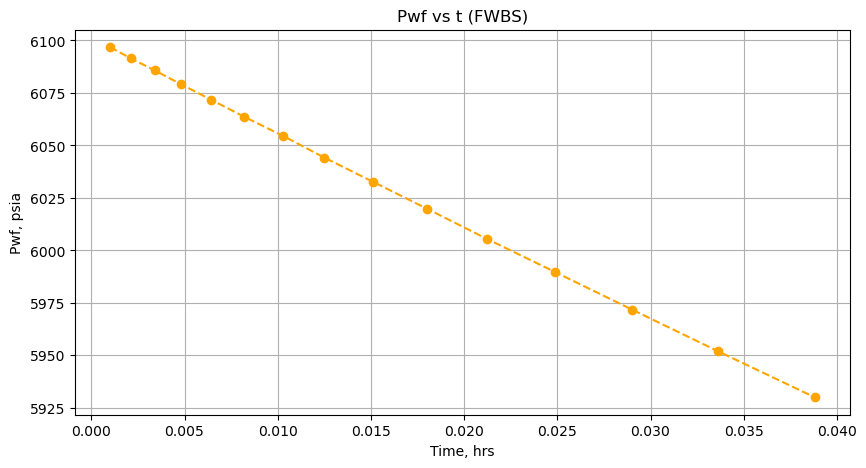

In [22]:
FWBS(0.001,0.04,df,d,'Conventional')

Conventional Method:
Reservoir Premability, K: 3.524 mD
Near Wellbore Skin, S: 3.516


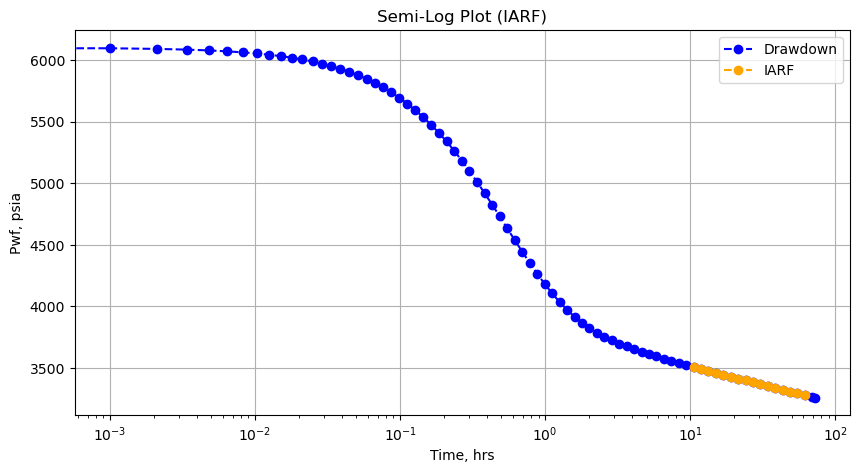

In [23]:
IARF(10,65,df,d,'Conventional')